In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/content/drive/MyDrive/new gait data/cleaned_rollator_data.csv")

In [ ]:
# Basic dataset exploration
print(f"Dataset dimensions: {df.shape}")
print(f"Number of participants: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(
    missing_values[missing_values > 0]
    if any(missing_values > 0)
    else "No missing values"
)

# Statistical summary of the data
summary = df.describe()
print("\nStatistical summary:")
print(summary)

Dataset dimensions: (60, 24)
Number of participants: 60
Number of features: 24

Missing values per column:
No missing values

Statistical summary:
       stride_count_with_rollator_slope_up  speed_with_rollator_slope_up  \
count                            60.000000                     60.000000   
mean                             62.846825                    119.544444   
std                               5.351140                      6.021072   
min                              52.000000                    104.000000   
25%                              59.000000                    116.000000   
50%                              62.000000                    118.000000   
75%                              67.047619                    122.000000   
max                              74.000000                    137.000000   

       stride_count_with_rollator_slope_down  speed_with_rollator_slope_down  \
count                               60.00000                       60.000000   
mean    

In [ ]:
# Check for realistic values
print("\nValue ranges:")
for col in df.columns:
    print(f"{col}: {df[col].min()} to {df[col].max()}")

# Verify if stride counts are within physiological ranges
stride_cols = [col for col in df.columns if "stride_count" in col]
for col in stride_cols:
    if df[col].max() > 200 or df[col].min() < 10:
        print(
            f"Suspicious stride count range in {col}: {df[col].min()} to {df[col].max()}"
        )

# Check if speed values are in expected range (typically 0.5-2.0 m/s for older adults)
speed_cols = [col for col in df.columns if "speed" in col]
for col in speed_cols:
    if df[col].max() > 200 or df[col].min() < 50:
        print(f"Suspicious speed range in {col}: {df[col].min()} to {df[col].max()}")

# Check if acceleration values are in expected range (typically -2 to 2 g)
accel_cols = [col for col in df.columns if "accel" in col]
for col in accel_cols:
    if df[col].max() > 3 or df[col].min() < -3:
        print(
            f"Suspicious acceleration range in {col}: {df[col].min()} to {df[col].max()}"
        )


Value ranges:
stride_count_with_rollator_slope_up: 52.0 to 74.0
speed_with_rollator_slope_up: 104.0 to 137.0
stride_count_with_rollator_slope_down: 31.0 to 52.0
speed_with_rollator_slope_down: 108.0 to 127.0
stride_count_with_rollator_gravel: 47.0 to 60.0
speed_with_rollator_gravel: 112.0 to 124.0
stride_count_with_rollator_sidewalk: 12.0 to 52.0
speed_with_rollator_sidewalk: 101.0 to 141.0
avg_z_accel_with_rollator_slope_up: 0.19656 to 0.253593
avg_z_accel_with_rollator_slope_down: 0.202874 to 0.244755
avg_z_accel_with_rollator_gravel: 0.189003 to 0.236686
avg_z_accel_with_rollator_sidewalk: 0.113314 to 0.26643
stride_count_without_rollator_slope_up: 38.0 to 47.0
speed_without_rollator_slope_up: 102.0 to 110.0
stride_count_without_rollator_slope_down: 38.0 to 58.0
speed_without_rollator_slope_down: 104.0 to 114.0
stride_count_without_rollator_gravel: 28.0 to 57.0
speed_without_rollator_gravel: 93.0 to 118.0
stride_count_without_rollator_sidewalk: 40.0 to 48.0
speed_without_rollator_s

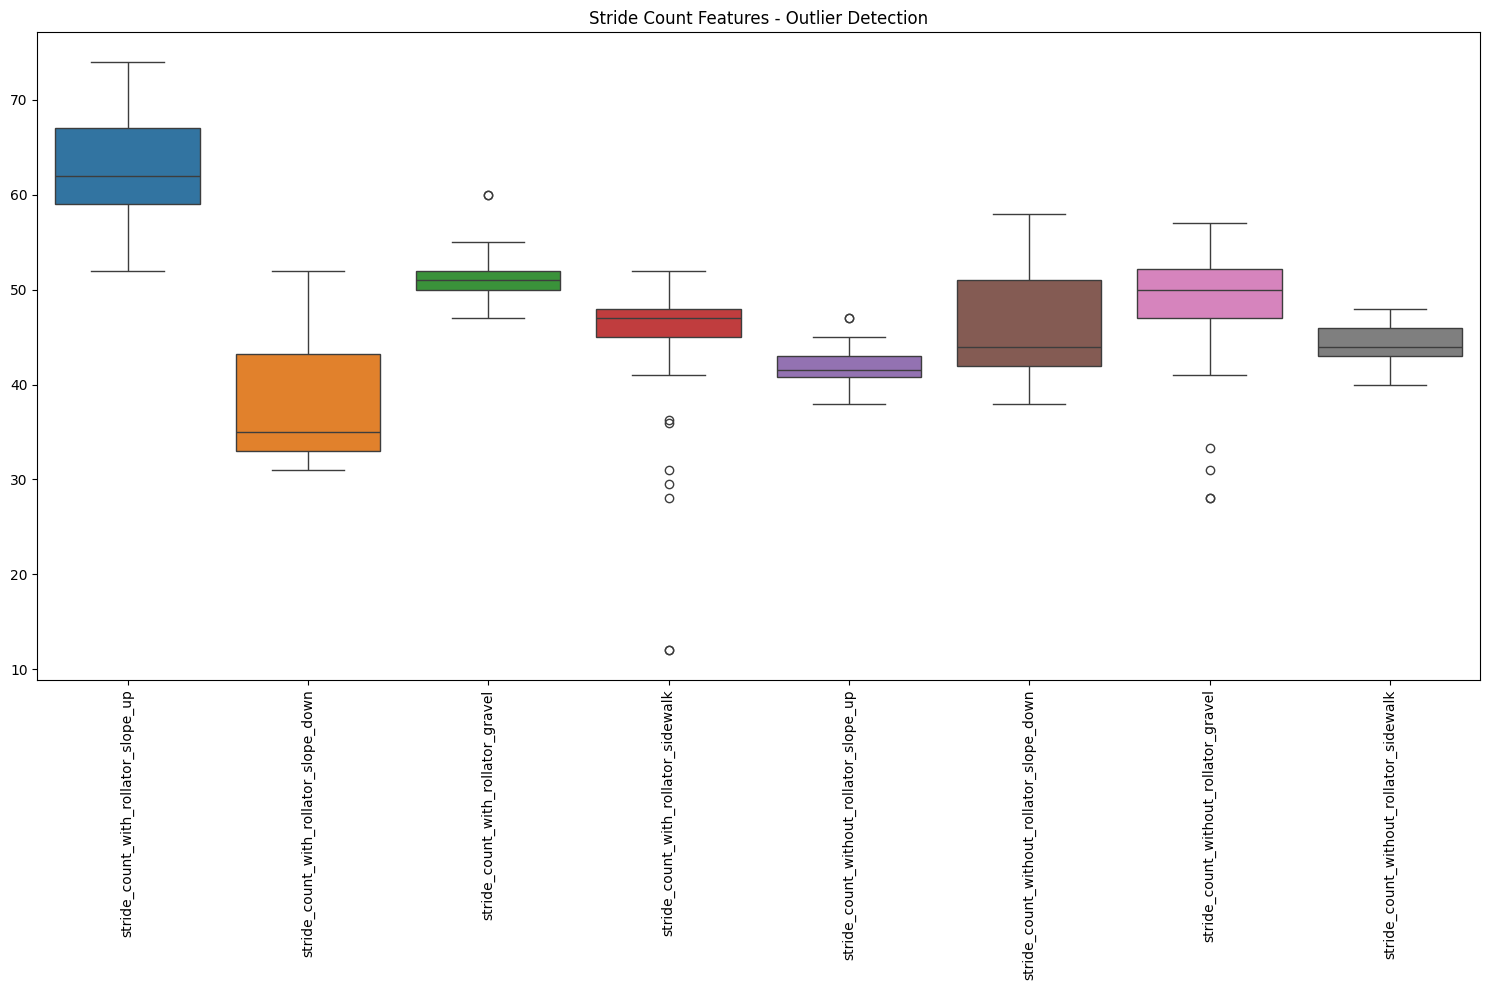

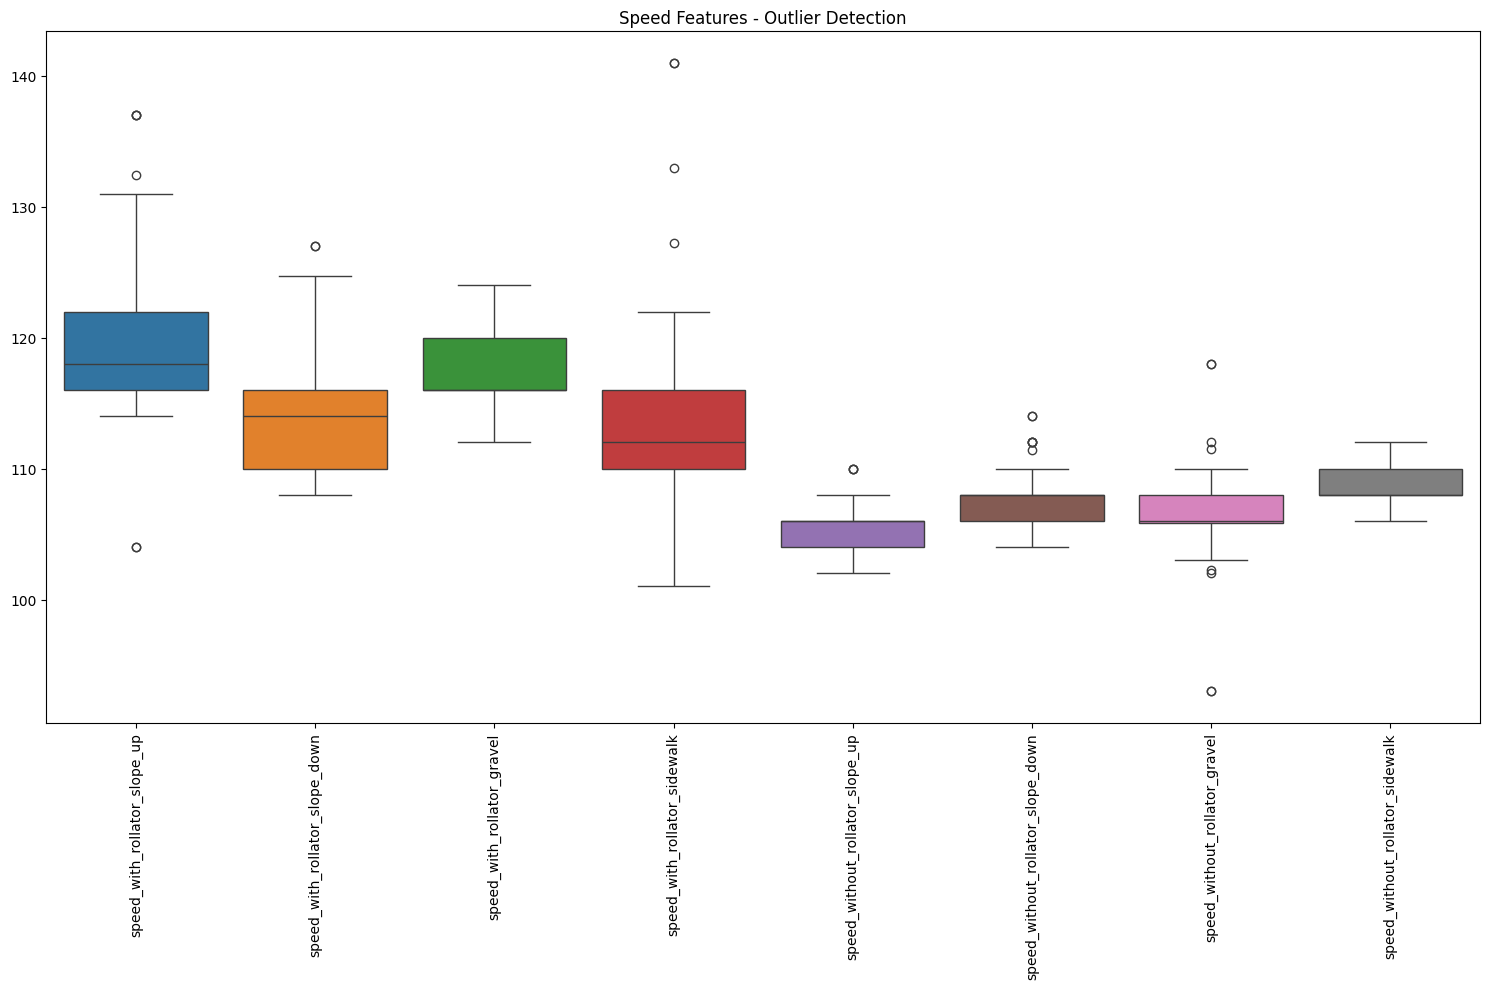

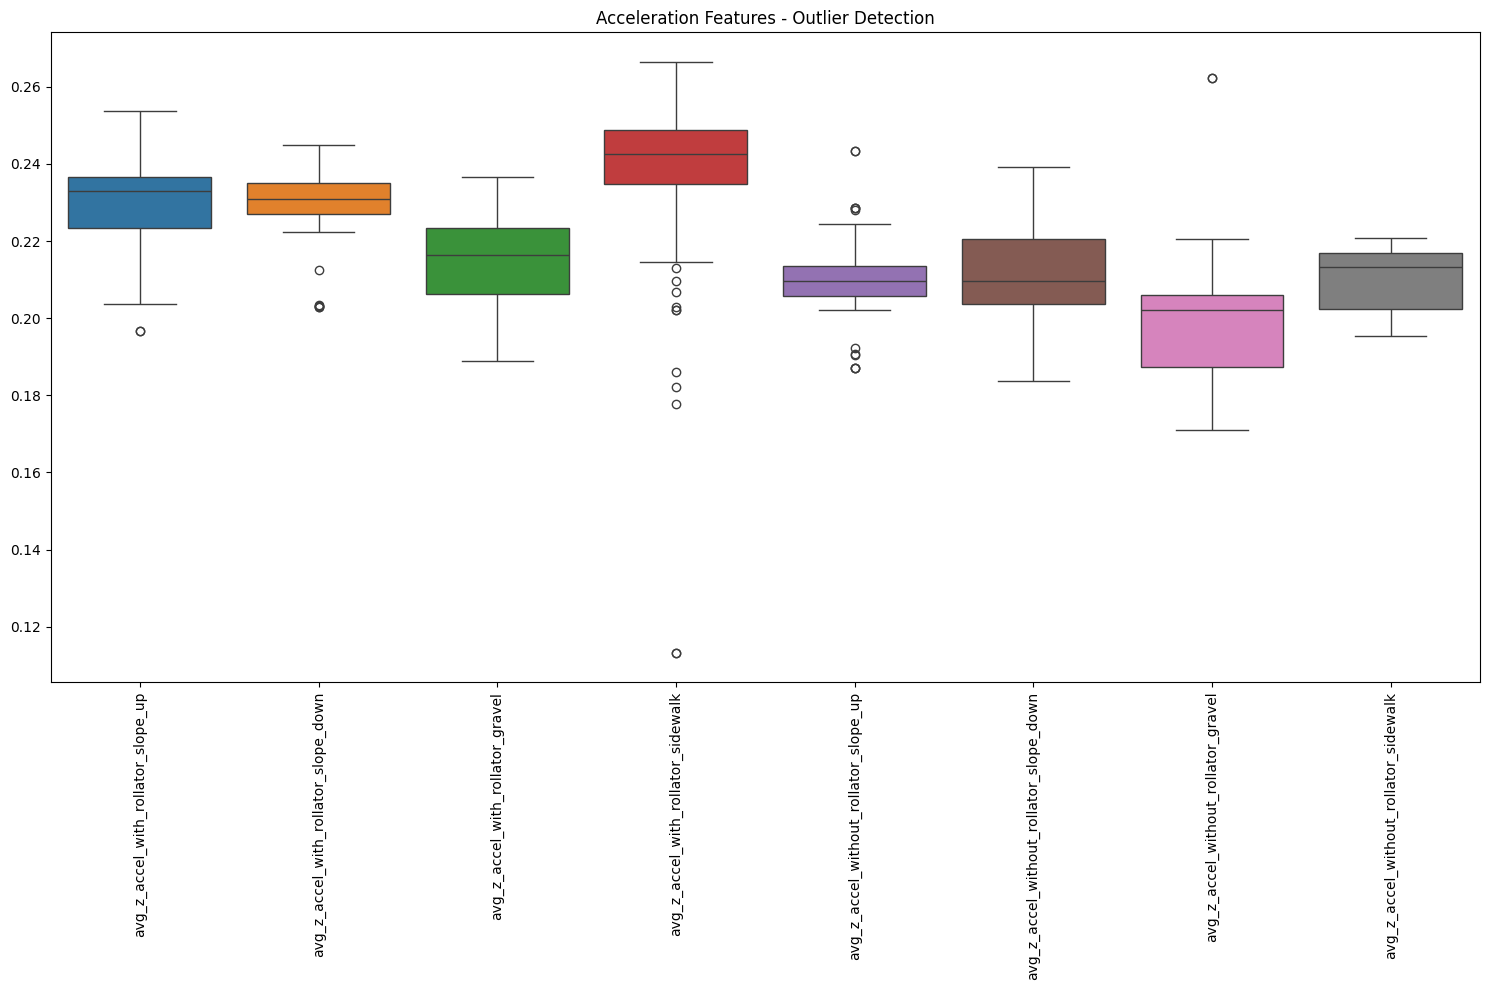


Potential outliers by column (using IQR method):
speed_with_rollator_slope_up: 6 outliers at indices [0, 27, 30, 39, 41, 43]
speed_with_rollator_slope_down: 2 outliers at indices [1, 59]
stride_count_with_rollator_gravel: 2 outliers at indices [6, 59]
stride_count_with_rollator_sidewalk: 7 outliers at indices [31, 32, 34, 35, 36, 37, 41]
speed_with_rollator_sidewalk: 4 outliers at indices [31, 35, 43, 59]
avg_z_accel_with_rollator_slope_up: 2 outliers at indices [1, 43]
avg_z_accel_with_rollator_slope_down: 6 outliers at indices [0, 1, 20, 21, 22, 23]
avg_z_accel_with_rollator_sidewalk: 11 outliers at indices [27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 41]
stride_count_without_rollator_slope_up: 2 outliers at indices [0, 59]
speed_without_rollator_slope_up: 3 outliers at indices [14, 16, 59]
speed_without_rollator_slope_down: 7 outliers at indices [4, 14, 15, 17, 57, 58, 59]
stride_count_without_rollator_gravel: 4 outliers at indices [31, 32, 33, 37]
speed_without_rollator_gravel: 8 outl

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Function to identify outliers using z-score
def find_outliers_zscore(df, col, threshold=3):
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    return df[abs(z_scores) > threshold].index


# Function to detect outliers using IQR
def find_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)].index


#  Check for outliers
# Create a boxplot for each feature category
# Group by measurement type
stride_count_cols = [col for col in df.columns if "stride_count" in col]
speed_cols = [
    col for col in df.columns if "speed" in col and "walking_speed" not in col
]
accel_cols = [col for col in df.columns if "accel" in col]

plt.figure(figsize=(15, 10))
sns.boxplot(data=df[stride_count_cols])
plt.title("Stride Count Features - Outlier Detection")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("stride_count_boxplot.png")
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df[speed_cols])
plt.title("Speed Features - Outlier Detection")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("speed_boxplot.png")
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df[accel_cols])
plt.title("Acceleration Features - Outlier Detection")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("accel_boxplot.png")
plt.show()

# List potential outliers
print("\nPotential outliers by column (using IQR method):")
for col in df.columns:
    outliers = find_outliers_iqr(df, col)
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers at indices {list(outliers)}")

In [ ]:
# Count outliers per participant
outlier_counts = {}
all_outlier_indices = set()

for col in df.columns:
    outliers = find_outliers_iqr(df, col)
    for idx in outliers:
        all_outlier_indices.add(idx)
        if idx in outlier_counts:
            outlier_counts[idx] += 1
        else:
            outlier_counts[idx] = 1

# Sort participants by number of outlier features
sorted_counts = {
    k: v
    for k, v in sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True)
}

print(f"Total participants with at least one outlier: {len(sorted_counts)}")
print(f"Participants with highest number of outliers:")
for idx, count in list(sorted_counts.items())[:5]:
    print(f"Participant {idx}: {count} outlier features")

Total participants with at least one outlier: 34
Participants with highest number of outliers:
Participant 59: 9 outlier features
Participant 31: 6 outlier features
Participant 0: 4 outlier features
Participant 1: 4 outlier features
Participant 41: 3 outlier features


In [ ]:
# Examine a few significant outlier cases
high_outlier_participants = list(sorted_counts.keys())[:3]
significant_columns = [
    "stride_count_with_rollator_sidewalk",
    "speed_with_rollator_sidewalk",
    "avg_z_accel_with_rollator_sidewalk",
    "stride_count_without_rollator_sidewalk",
    "speed_without_rollator_sidewalk",
    "avg_z_accel_without_rollator_sidewalk",
]

print("\nDetailed view of top outlier participants:")
print(df.loc[high_outlier_participants, significant_columns])

# Compare with non-outlier statistics
non_outlier_indices = [i for i in range(df.shape[0]) if i not in all_outlier_indices]
print("\nNon-outlier statistics:")
print(df.loc[non_outlier_indices, significant_columns].describe())


Detailed view of top outlier participants:
    stride_count_with_rollator_sidewalk  speed_with_rollator_sidewalk  \
59                            50.478261                     127.26087   
31                            28.000000                     133.00000   
0                             46.000000                     114.00000   

    avg_z_accel_with_rollator_sidewalk  \
59                            0.253165   
31                            0.209738   
0                             0.244541   

    stride_count_without_rollator_sidewalk  speed_without_rollator_sidewalk  \
59                                    48.0                            112.0   
31                                    41.0                            108.0   
0                                     45.0                            106.0   

    avg_z_accel_without_rollator_sidewalk  
59                               0.220791  
31                               0.202392  
0                                0.220588  



Use winsorization: For statistical modeling, use winsorized data to reduce the influence of extreme values while preserving participant count

In [ ]:
# 1. Flag outliers for documentation
outlier_flags = pd.DataFrame(index=df.index)
for col in df.columns:
    outliers = find_outliers_iqr(df, col)
    outlier_flags[f"{col}_is_outlier"] = 0
    outlier_flags.loc[outliers, f"{col}_is_outlier"] = 1

# 2. Create a copy with winsorized data for modeling
df_winsorized = df.copy()
for col in df.columns:
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    df_winsorized[col] = df[col].clip(lower=Q1, upper=Q3)

# 3. Document the impact of outlier treatment
print("\nImpact of outlier treatment on key statistics:")
for col in significant_columns:
    print(f"\n{col}:")
    print(f"Original Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f}")
    print(
        f"Winsorized Mean: {df_winsorized[col].mean():.2f}, Std: {df_winsorized[col].std():.2f}"
    )
    outlier_indices = find_outliers_iqr(df, col)
    print(
        f"Number of outliers: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.1f}%)"
    )

# 4. Save both versions for analysis
df_winsorized.to_csv("gait_data_winsorized.csv", index=False)
outlier_flags.to_csv("gait_data_outlier_flags.csv", index=True)


Impact of outlier treatment on key statistics:

stride_count_with_rollator_sidewalk:
Original Mean: 44.69, Std: 7.80
Winsorized Mean: 45.24, Std: 5.52
Number of outliers: 7 (11.7%)

speed_with_rollator_sidewalk:
Original Mean: 113.83, Std: 7.09
Winsorized Mean: 113.53, Std: 4.90
Number of outliers: 4 (6.7%)

avg_z_accel_with_rollator_sidewalk:
Original Mean: 0.23, Std: 0.03
Winsorized Mean: 0.24, Std: 0.02
Number of outliers: 11 (18.3%)

stride_count_without_rollator_sidewalk:
Original Mean: 44.16, Std: 2.09
Winsorized Mean: 44.20, Std: 2.03
Number of outliers: 0 (0.0%)

speed_without_rollator_sidewalk:
Original Mean: 108.68, Std: 1.74
Winsorized Mean: 108.68, Std: 1.74
Number of outliers: 0 (0.0%)

avg_z_accel_without_rollator_sidewalk:
Original Mean: 0.21, Std: 0.01
Winsorized Mean: 0.21, Std: 0.01
Number of outliers: 0 (0.0%)
